<a href="https://colab.research.google.com/github/IoannisK97/Level5Project/blob/main/Lorenz_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dysts

In [ ]:
from dysts.flows import Lorenz
import numpy as np

model = Lorenz()
sol = model.make_trajectory(1000)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math


print(type(sol))
lorenz_df=pd.DataFrame(sol,columns=['x','y','z'])
lorenz_df

<class 'numpy.ndarray'>


,x,y,z
0,-9.786929,-15.038520,20.533978
1,-10.578278,-15.834483,22.046015
2,-11.356836,-16.430545,23.790957
3,-12.091196,-16.752521,25.727890
4,-12.744264,-16.732002,27.787265
...,...,...,...
995,5.976205,10.223297,14.098617
996,6.648860,11.358285,14.548117
997,7.391196,12.562541,15.213612
998,8.201381,13.809041,16.130898


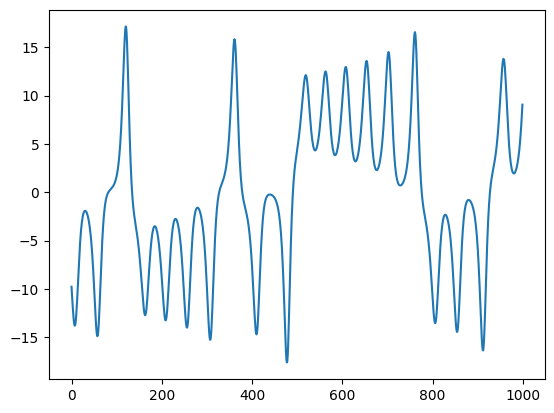

In [ ]:
plt.plot(sol[:, 0])

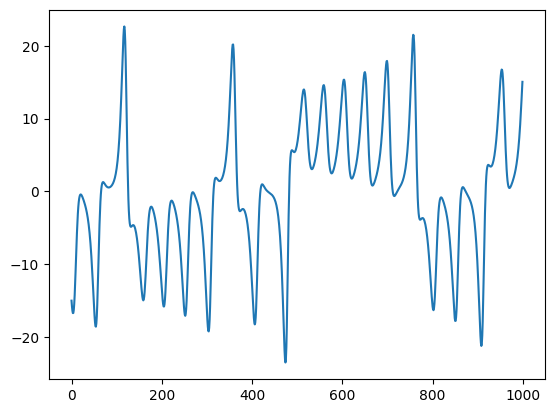

In [ ]:
plt.plot(sol[:, 1])

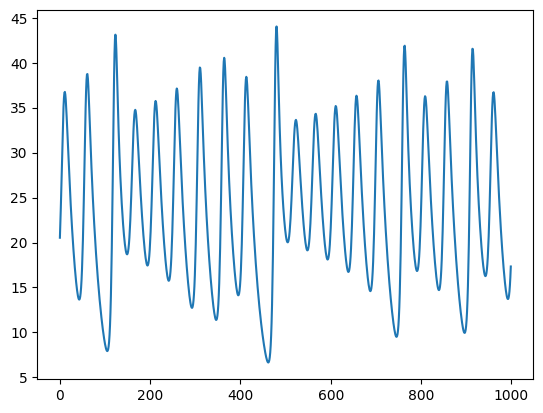

In [ ]:
plt.plot(sol[:, 2])

In [ ]:
training_data_len = math.ceil(len(lorenz_df) * 0.8)

train_data = lorenz_df[:training_data_len]
test_data = lorenz_df[training_data_len:]
print(train_data.shape, test_data.shape)

(800, 3) (200, 3)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Extracting x, y, z values
dataset_train = train_data[['x', 'y', 'z']].values
dataset_test = test_data[['x', 'y', 'z']].values

# Reshape dataset to 2D if necessary
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(dataset_train)
scaled_test = scaler.transform(dataset_test)


In [ ]:
import torch


# Setting sequence length
sequence_length = 10

# Create sequences for training data
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i + sequence_length])
    y_train.append(scaled_train[i + sequence_length])  # Predicting the values after the sequence

X_train, y_train = np.array(X_train), np.array(y_train)

# Create sequences for testing data
sequence_length = 10  # We can set a different length for testing if we want
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i + sequence_length])
    y_test.append(scaled_test[i + sequence_length])

X_test, y_test = np.array(X_test), np.array(y_test)


print("Training Tensor Shapes: ", X_train.shape, y_train.shape)
print("Testing Tensor Shapes: ", X_test.shape, y_test.shape)
print(X_test[0])
print(y_test[0])
print(X_test[1])



Training Tensor Shapes:  (790, 10, 3) (790, 3)
Testing Tensor Shapes:  (190, 10, 3) (190, 3)
[[0.19178787 0.16631046 0.44746269]
 [0.17126323 0.15776274 0.49461945]
 [0.1526072  0.15562912 0.54543854]
 [0.1368592  0.16102442 0.5977607 ]
 [0.12507393 0.17453588 0.64885355]
 [0.1181997  0.19600568 0.69568478]
 [0.11694307 0.22442718 0.73533128]
 [0.12164916 0.25801532 0.76543452]
 [0.13222919 0.29445819 0.78457308]
 [0.14815763 0.33128837 0.79243753]]
[0.16854144 0.36626636 0.78976209]
[[0.17126323 0.15776274 0.49461945]
 [0.1526072  0.15562912 0.54543854]
 [0.1368592  0.16102442 0.5977607 ]
 [0.12507393 0.17453588 0.64885355]
 [0.1181997  0.19600568 0.69568478]
 [0.11694307 0.22442718 0.73533128]
 [0.12164916 0.25801532 0.76543452]
 [0.13222919 0.29445819 0.78457308]
 [0.14815763 0.33128837 0.79243753]
 [0.16854144 0.36626636 0.78976209]]


In [ ]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print("Training Tensor Shapes: ", X_train.shape, y_train.shape)
print("Testing Tensor Shapes: ", X_test.shape, y_test.shape)



Training Tensor Shapes:  torch.Size([790, 10, 3]) torch.Size([790, 3])
Testing Tensor Shapes:  torch.Size([190, 10, 3]) torch.Size([190, 3])


In [ ]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, 3)  # Predicting all three values: x, y, z

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])  # Take the output from the last time step
        return out


In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

input_size = 3
hidden_size = 32
num_layers = 2
dropout = 0.2

model = LSTMModel(input_size, hidden_size, num_layers, dropout).to(device)
loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


cpu


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
dataset_train_var = np.var(scaled_train, axis=0)
dataset_train_std = np.std(scaled_test, axis=0)

print(f'Variance of Training Data: X: {dataset_train_var[0]:.4f}, Y: {dataset_train_var[1]:.4f}, Z: {dataset_train_var[2]:.4f}')
print(f'Standard Deviation of Training Data: X: {dataset_train_std[0]:.4f}, Y: {dataset_train_std[1]:.4f}, Z: {dataset_train_std[2]:.4f}')

Variance of Training Data: X: 0.0520, Y: 0.0382, Z: 0.0529
Standard Deviation of Training Data: X: 0.2160, Y: 0.1891, Z: 0.2278


In [ ]:

num_epochs = 100
train_hist = []
test_hist = []

#early stopping
patience = 10
min_delta = 0.0001
best_test_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    # Evaluation phase
    model.eval()
    total_test_loss = 0.0
    with torch.no_grad():
        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)
            total_test_loss += test_loss.item()

    average_test_loss = total_test_loss / len(test_loader)
    test_hist.append(average_test_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

    #early stopping
    if average_test_loss < best_test_loss - min_delta:
        best_test_loss = average_test_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break


Epoch [10/100], Training Loss: 0.0310, Test Loss: 0.0250
Epoch [20/100], Training Loss: 0.0178, Test Loss: 0.0126
Epoch [30/100], Training Loss: 0.0150, Test Loss: 0.0061
Epoch [40/100], Training Loss: 0.0128, Test Loss: 0.0049
Epoch [50/100], Training Loss: 0.0122, Test Loss: 0.0061
Early stopping at epoch 50


In [ ]:
model.eval()
predictions_2 = []
actuals = []

with torch.no_grad():
    for batch_X_test, batch_y_test in test_loader:
        batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
        predictions_test = model(batch_X_test)
        predictions_2.extend(predictions_test.cpu().numpy())
        actuals.extend(batch_y_test.cpu().numpy())

MAE for X: 0.0062, Y: 0.0057, Z: 0.0065
MSE for X: 0.0000, Y: 0.0001, Z: 0.0001


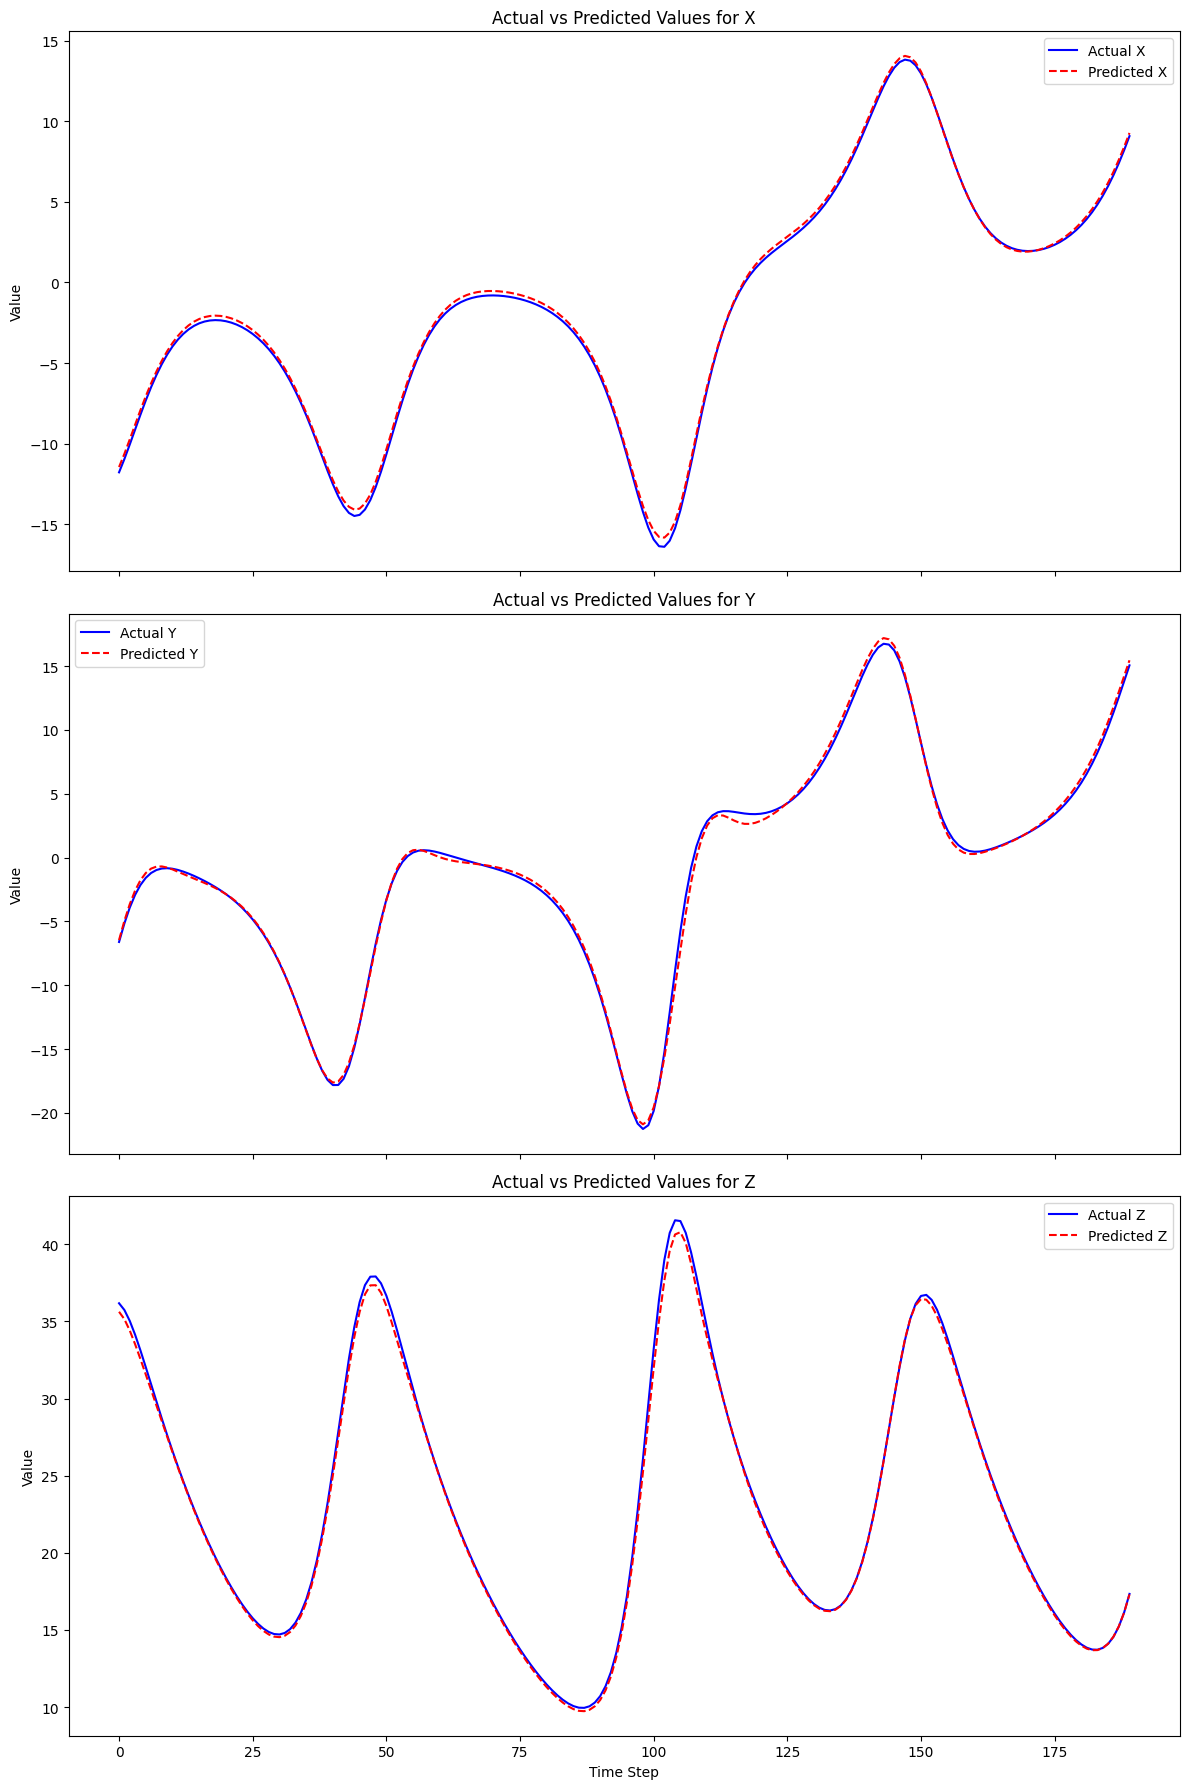

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


predictions_2 = np.array(predictions_2)
actuals = np.array(actuals)


# evaluation metrics
mae_x = mean_absolute_error(actuals[:, 0], predictions_2[:, 0])
mae_y = mean_absolute_error(actuals[:, 1], predictions_2[:, 1])
mae_z = mean_absolute_error(actuals[:, 2], predictions_2[:, 2])

mse_x = mean_squared_error(actuals[:, 0], predictions_2[:, 0])
mse_y = mean_squared_error(actuals[:, 1], predictions_2[:, 1])
mse_z = mean_squared_error(actuals[:, 2], predictions_2[:, 2])

print(f'MAE for X: {mae_x:.4f}, Y: {mae_y:.4f}, Z: {mae_z:.4f}')
print(f'MSE for X: {mse_x:.4f}, Y: {mse_y:.4f}, Z: {mse_z:.4f}')


predictions_2 = scaler.inverse_transform(predictions_2)
actuals = scaler.inverse_transform(actuals)


# Plot actual vs predicted values for x, y, z
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

#X
axes[0].plot(actuals[:, 0], label='Actual X', color='blue')
axes[0].plot(predictions_2[:, 0], label='Predicted X', linestyle='--', color='red')
axes[0].set_title('Actual vs Predicted Values for X')
axes[0].set_ylabel('Value')
axes[0].legend()

#Y
axes[1].plot(actuals[:, 1], label='Actual Y', color='blue')
axes[1].plot(predictions_2[:, 1], label='Predicted Y', linestyle='--', color='red')
axes[1].set_title('Actual vs Predicted Values for Y')
axes[1].set_ylabel('Value')
axes[1].legend()

# Z
axes[2].plot(actuals[:, 2], label='Actual Z', color='blue')
axes[2].plot(predictions_2[:, 2], label='Predicted Z', linestyle='--', color='red')
axes[2].set_title('Actual vs Predicted Values for Z')
axes[2].set_xlabel('Time Step')
axes[2].set_ylabel('Value')
axes[2].legend()

plt.tight_layout()
plt.show()